In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

In [2]:
diff_data = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\diff_comparison_diff_data.h5',key="df")

In [3]:
no_diff_data = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\diff_comparison_data.h5',key="df")

In [4]:
diff_data = diff_data[diff_data.test_device !=47683]
diff_data = diff_data[diff_data.test_device !=49103]
diff_data

title  test_device    scores   fit_times  pred_times
0   with_diff        31948  0.897338  333.501160    7.917090
2   with_diff        48790  0.853433  152.609500   13.799233
4   with_diff        49444  0.707875  154.686371    4.550026
5   with_diff        49446  0.651096  149.697976    8.785964
6   with_diff        49465  0.569685  152.133754    2.571575
7   with_diff        49486  0.784535   54.998368    6.097355
8   with_diff        49589  0.642701  161.715714    9.518129
9   with_diff        52040  0.454438  151.663435    1.604350
10  with_diff        52049  0.713297  151.857011    6.802520
11  with_diff        52148  0.729037  151.925571    6.710500
12  with_diff        59396  0.810188  147.159266    0.456103
13  with_diff        59497  0.666031  144.356094    0.900201
14  with_diff        59519  0.736199  154.047866    0.318072

In [5]:
no_diff_data = no_diff_data[no_diff_data.test_device !=47683]
no_diff_data = no_diff_data[no_diff_data.test_device !=49103]
no_diff_data

title  test_device    scores  fit_times  pred_times
0   no_diff        31948  0.857095  82.120682    4.785703
2   no_diff        48790  0.856866  79.641953    8.050809
4   no_diff        49444  0.695904  81.285998    2.720767
5   no_diff        49446  0.654679  81.525878    5.434215
6   no_diff        49465  0.582685  82.393962    1.555340
7   no_diff        49486  0.770822  35.095403    5.950322
8   no_diff        49589  0.614507  80.610453    5.923316
9   no_diff        52040  0.431872  82.695747    0.917205
10  no_diff        52049  0.705437  82.752100    4.190927
11  no_diff        52148  0.692934  83.054046    4.034893
12  no_diff        59396  0.807852  80.835473    0.281064
13  no_diff        59497  0.742060  77.258608    0.570429
14  no_diff        59519  0.755143  84.282415    0.183041

In [6]:
df = diff_data.append(no_diff_data)

In [7]:
df

title  test_device    scores   fit_times  pred_times
0   with_diff        31948  0.897338  333.501160    7.917090
2   with_diff        48790  0.853433  152.609500   13.799233
4   with_diff        49444  0.707875  154.686371    4.550026
5   with_diff        49446  0.651096  149.697976    8.785964
6   with_diff        49465  0.569685  152.133754    2.571575
7   with_diff        49486  0.784535   54.998368    6.097355
8   with_diff        49589  0.642701  161.715714    9.518129
9   with_diff        52040  0.454438  151.663435    1.604350
10  with_diff        52049  0.713297  151.857011    6.802520
11  with_diff        52148  0.729037  151.925571    6.710500
12  with_diff        59396  0.810188  147.159266    0.456103
13  with_diff        59497  0.666031  144.356094    0.900201
14  with_diff        59519  0.736199  154.047866    0.318072
0     no_diff        31948  0.857095   82.120682    4.785703
2     no_diff        48790  0.856866   79.641953    8.050809
4     no_diff        49444  0.695904   81.285998    2.720767
5     no_diff        49446  0.654679   81.525878    5.434215
6     no_diff        49465  0.582685   82.393962    1.555340
7     no_diff        49486  0.770822   35.095403    5.950322
8     no_diff        49589  0.614507   80.610453    5.923316
9     no_diff        52040  0.431872   82.695747    0.917205
10    no_diff        52049  0.705437   82.752100    4.190927
11    no_diff        52148  0.692934   83.054046    4.034893
12    no_diff        59396  0.807852   80.835473    0.281064
13    no_diff        59497  0.742060   77.258608    0.570429
14    no_diff        59519  0.755143   84.282415    0.183041

[Text(0, 0, 'with_diff'), Text(0, 0, 'no_diff')]

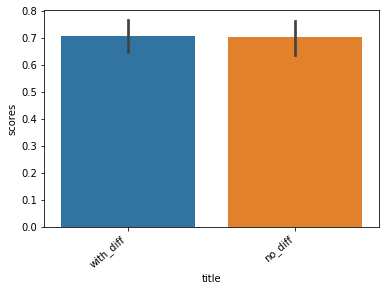

In [8]:
ax = sns.barplot(x="title", y="scores", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, 'with_diff'), Text(0, 0, 'no_diff')]

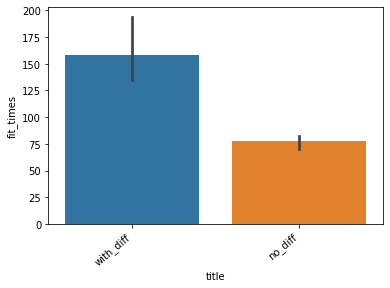

In [9]:
ax = sns.barplot(x="title", y="fit_times", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [10]:
df = preprocessing.load_relevant_data()

In [11]:
df

doy_id  temperature            datetime  device_id
0       31948:2019:13         20.3 2019-01-13 04:59:02      31948
1       31948:2019:13         20.3 2019-01-13 05:02:01      31948
2       31948:2019:13         20.3 2019-01-13 05:05:00      31948
3       31948:2019:13         20.3 2019-01-13 05:07:59      31948
4       31948:2019:13         20.3 2019-01-13 05:10:58      31948
...               ...          ...                 ...        ...
515934  31948:2019:13         20.4 2019-01-13 04:44:07      31948
515935  31948:2019:13         20.4 2019-01-13 04:47:06      31948
515936  31948:2019:13         20.3 2019-01-13 04:50:05      31948
515937  31948:2019:13         20.3 2019-01-13 04:53:04      31948
515938  31948:2019:13         20.3 2019-01-13 04:56:03      31948

[497434 rows x 4 columns]

In [12]:
df[df.device_id == 47683]

doy_id  temperature            datetime  device_id
50718  47683:2019:182         28.8 2019-07-01 03:41:12      47683
50719  47683:2019:182         28.8 2019-07-01 03:44:11      47683
50720  47683:2019:182         28.8 2019-07-01 03:47:10      47683
50721  47683:2019:182         28.8 2019-07-01 03:50:09      47683
50722  47683:2019:182         28.8 2019-07-01 03:53:08      47683
...               ...          ...                 ...        ...
50969  47683:2019:182         28.7 2019-07-01 16:10:01      47683
50970  47683:2019:182         28.7 2019-07-01 16:13:00      47683
50971  47683:2019:182         28.7 2019-07-01 16:15:59      47683
50972  47683:2019:182         28.7 2019-07-01 16:18:58      47683
50973  47683:2019:182         28.7 2019-07-01 16:21:57      47683

[256 rows x 4 columns]

In [13]:
df[df.device_id == 49103]

doy_id  temperature            datetime  device_id
52554   49103:2019:203         24.7 2019-07-22 18:52:47      49103
52555   49103:2019:203         24.0 2019-07-22 18:55:46      49103
52556   49103:2019:203         22.3 2019-07-22 18:59:27      49103
52557   49103:2019:203         10.4 2019-07-22 19:06:12      49103
52558   49103:2019:203          7.6 2019-07-22 19:09:42      49103
...                ...          ...                 ...        ...
141514  49103:2019:235          5.0 2019-08-23 12:10:56      49103
141515  49103:2019:235          4.7 2019-08-23 12:13:55      49103
141516  49103:2019:235          4.3 2019-08-23 12:16:54      49103
141590  49103:2019:235          3.6 2019-08-23 12:22:12      49103
141591  49103:2019:235          3.1 2019-08-23 12:25:11      49103

[8269 rows x 4 columns]

In [14]:
features,y = preprocessing.load_feature_data()

In [15]:
features

temperature__variance_larger_than_standard_deviation  \
59497 99                                                 1.0      
      100                                                1.0      
      101                                                1.0      
      102                                                1.0      
      103                                                1.0      
...                                                      ...      
47683 151                                                1.0      
      152                                                1.0      
      153                                                1.0      
      154                                                1.0      
      155                                                1.0      

           temperature__has_duplicate_max  temperature__has_duplicate_min  \
59497 99                              0.0                             0.0   
      100                             0.0                             0.0   
      101                             0.0                             0.0   
      102                             0.0                             0.0   
      103                             0.0                             0.0   
...                                   ...                             ...   
47683 151                             1.0                             1.0   
      152                             1.0                             1.0   
      153                             1.0                             1.0   
      154                             1.0                             1.0   
      155                             1.0                             1.0   

           temperature__has_duplicate  temperature__sum_values  \
59497 99                          1.0                    548.0   
      100                         1.0                    536.5   
      101                         1.0                    529.8   
      102                         1.0                    526.4   
      103                         1.0                    524.9   
...                               ...                      ...   
47683 151                         1.0                   2682.2   
      152                         1.0                   2680.3   
      153                         1.0                   2678.5   
      154                         1.0                   2676.7   
      155                         1.0                   2674.8   

           temperature__abs_energy  temperature__mean_abs_change  \
59497 99                   3750.48                      0.270707   
      100                  3436.53                      0.224242   
      101                  3284.44                      0.191919   
      102                  3218.48                      0.173737   
      103                  3191.93                      0.167677   
...                            ...                           ...   
47683 151                 72109.48                      0.051515   
      152                 72004.41                      0.051515   
      153                 71904.69                      0.052525   
      154                 71804.97                      0.051515   
      155                 71699.52                      0.051515   

           temperature__mean_change  \
59497 99                  -0.117172   
      100                 -0.068687   
      101                 -0.034343   
      102                 -0.016162   
      103                 -0.008081   
...                             ...   
47683 151                 -0.019192   
      152                 -0.019192   
      153                 -0.018182   
      154                 -0.019192   
      155                 -0.019192   

           temperature__mean_second_derivative_central  temperature__median  \
59497 99                                  2.448980e-02                 5.45   
      100                                 1.

In [18]:
features.drop(47683,level=0)

temperature__variance_larger_than_standard_deviation  \
59497 99                                                  1.0      
      100                                                 1.0      
      101                                                 1.0      
      102                                                 1.0      
      103                                                 1.0      
...                                                       ...      
59519 2107                                                0.0      
      2108                                                0.0      
      2109                                                0.0      
      2110                                                0.0      
      2111                                                0.0      

            temperature__has_duplicate_max  temperature__has_duplicate_min  \
59497 99                               0.0                             0.0   
      100                              0.0                             0.0   
      101                              0.0                             0.0   
      102                              0.0                             0.0   
      103                              0.0                             0.0   
...                                    ...                             ...   
59519 2107                             1.0                             1.0   
      2108                             1.0                             1.0   
      2109                             1.0                             1.0   
      2110                             1.0                             0.0   
      2111                             1.0                             0.0   

            temperature__has_duplicate  temperature__sum_values  \
59497 99                           1.0                    548.0   
      100                          1.0                    536.5   
      101                          1.0                    529.8   
      102                          1.0                    526.4   
      103                          1.0                    524.9   
...                                ...                      ...   
59519 2107                         1.0                    175.7   
      2108                         1.0                    175.3   
      2109                         1.0                    174.9   
      2110                         1.0                    174.4   
      2111                         1.0                    174.0   

            temperature__abs_energy  temperature__mean_abs_change  \
59497 99                    3750.48                      0.270707   
      100                   3436.53                      0.224242   
      101                   3284.44                      0.191919   
      102                   3218.48                      0.173737   
      103                   3191.93                      0.167677   
...                             ...                           ...   
59519 2107                   310.69                      0.004040   
      2108                   309.25                      0.004040   
      2109                   307.81                      0.004040   
      2110                   306.06                      0.005051   
      2111                   304.62                      0.006061   

            temperature__mean_change  \
59497 99                   -0.117172   
      100                  -0.068687   
      101                  -0.034343   
      102                  -0.016162   
      103                  -0.008081   
...                              ...   
59519 2107                 -0.004040   
      2108                 -0.004040   
      2109                 -0.004040   
      2110                 -0.005051   
      2111                 -0.004040   

            temperature__mean_second_derivative_central  temperature__median  \
59497 99                                       0.024490        

In [19]:
features.drop(49103,level=0)

temperature__variance_larger_than_standard_deviation  \
59497 99                                                 1.0      
      100                                                1.0      
      101                                                1.0      
      102                                                1.0      
      103                                                1.0      
...                                                      ...      
47683 151                                                1.0      
      152                                                1.0      
      153                                                1.0      
      154                                                1.0      
      155                                                1.0      

           temperature__has_duplicate_max  temperature__has_duplicate_min  \
59497 99                              0.0                             0.0   
      100                             0.0                             0.0   
      101                             0.0                             0.0   
      102                             0.0                             0.0   
      103                             0.0                             0.0   
...                                   ...                             ...   
47683 151                             1.0                             1.0   
      152                             1.0                             1.0   
      153                             1.0                             1.0   
      154                             1.0                             1.0   
      155                             1.0                             1.0   

           temperature__has_duplicate  temperature__sum_values  \
59497 99                          1.0                    548.0   
      100                         1.0                    536.5   
      101                         1.0                    529.8   
      102                         1.0                    526.4   
      103                         1.0                    524.9   
...                               ...                      ...   
47683 151                         1.0                   2682.2   
      152                         1.0                   2680.3   
      153                         1.0                   2678.5   
      154                         1.0                   2676.7   
      155                         1.0                   2674.8   

           temperature__abs_energy  temperature__mean_abs_change  \
59497 99                   3750.48                      0.270707   
      100                  3436.53                      0.224242   
      101                  3284.44                      0.191919   
      102                  3218.48                      0.173737   
      103                  3191.93                      0.167677   
...                            ...                           ...   
47683 151                 72109.48                      0.051515   
      152                 72004.41                      0.051515   
      153                 71904.69                      0.052525   
      154                 71804.97                      0.051515   
      155                 71699.52                      0.051515   

           temperature__mean_change  \
59497 99                  -0.117172   
      100                 -0.068687   
      101                 -0.034343   
      102                 -0.016162   
      103                 -0.008081   
...                             ...   
47683 151                 -0.019192   
      152                 -0.019192   
      153                 -0.018182   
      154                 -0.019192   
      155                 -0.019192   

           temperature__mean_second_derivative_central  temperature__median  \
59497 99                                  2.448980e-02                 5.45   
      100                                 1.